## wine quality prediction based on chemical properties

- predict the quality of a wine based on the chemical properties of the wine.
- dataset: wine quality dataset hosted on the <a href="https://archive.ics.uci.edu/ml/datasets/Wine+Quality">UCI website</a>. 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score

###  Data preparation

Import data

In [2]:
df = pd.read_csv('winequality-red.csv',sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


total 1599. no NaN object.

features: all columns except quality.
target: quality
classified quality into bad(score<7) or good (>7) into 0 or 1.

In [140]:
Y = df.quality.values
dfx = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])

Use the <a href='http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.as_matrix.html'>as_matrix</a> function in Pandas to **save the feature information in your data frame as a numpy array**. This is the $X$ matrix.

In [156]:
# save feautre into numpy array
X = dfx.as_matrix()
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X)
#X=scaler.transform(X)
#plt.scatter(X[:,0],X[:,9])

### build random forest
- varying number of trees
- use 10-fold cross-validation.

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

In [158]:
# modeling
scores =[]
treen= []
for i in range(1,21):
    forest_clf = RandomForestClassifier(n_estimators=i)
    score_list = cross_val_score(forest_clf,X,Y,cv=10)
    scores.append(score_list)
    treen.append(i)

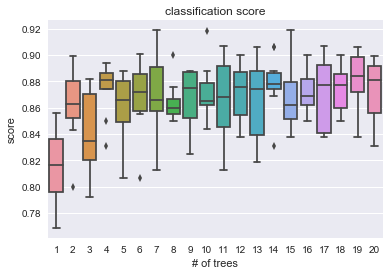

In [159]:
# plot results
sns.boxplot(x=treen,y=scores)
plt.xlabel('# of trees')
plt.ylabel('score')
plt.title('classification score')
plt.show()

after ~ 15 trees. score not much different.

In [168]:
blind_guess_score = sum(1-Y)/float(len(Y))
print (100*float(sum(1-Y))/len(Y))

86.42901813633522


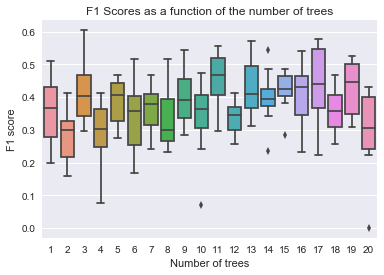

In [176]:
# your code here
scores = []
treen = []
for i in range(1,21):
    clf = RandomForestClassifier(n_estimators = i)
    score_list = cross_val_score(clf, X, Y, cv=10, scoring='f1')
    scores.append(score_list)
    treen.append(i)

sns.boxplot(x=treen,y=scores)
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 Scores as a function of the number of trees')
plt.show()

### calibration

In [183]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [185]:
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1] > cutoff).astype(int)

In [186]:
def custom_f1(cutoff):
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, cutoff)
        return sklearn.metrics.f1_score(y, ypred)
        
    return f1_cutoff

In [197]:
scores = []
cutoffi = []
for cutoff in np.arange(0.1,0.9,0.1):
    clf = RandomForestClassifier(n_estimators=15)
    score_list = cross_val_score(clf,X,Y,cv=10,scoring=custom_f1(cutoff))
    scores.append(score_list)
    cutoffi.append(cutoff)

/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


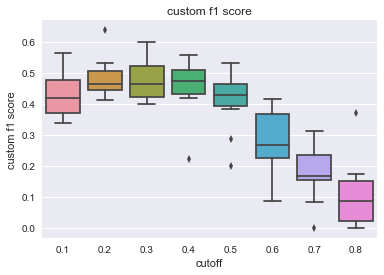

In [198]:
sns.boxplot(x=cutoffi,y=scores)
plt.xlabel('cutoff')
plt.ylabel('custom f1 score')
plt.title('custom f1 score')
plt.show()

- cutoff about 0.2 to 0.3 give the best custom f1 score.
- because most of the wine are 'bad'. therefore adjusting the cut-off to 0.2 can balance the recall and precision and improve f1.


### visualize decision surface

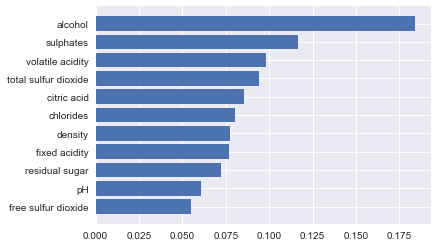

In [210]:
# identifying the most important factors.
clf.fit(X,Y)
list_importance = clf.feature_importances_
list_name = df.columns
list_importance, list_name = zip(*sorted(zip(list_importance, list_name)))
plt.barh(range(len(list_importance)),list_importance)
plt.yticks(range(len(list_name)),list_name)
plt.show()

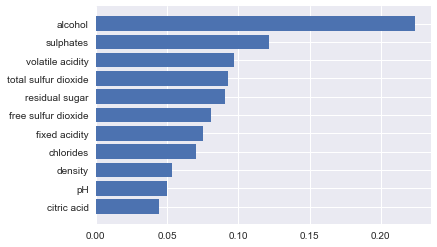

In [219]:
# identifying the most important factors.
from sklearn.tree import DecisionTreeClassifier

clf=DecisionTreeClassifier()
clf.fit(X,Y)
list_importance = clf.feature_importances_
list_name = df.columns
list_importance, list_name = zip(*sorted(zip(list_importance, list_name)))
plt.barh(range(len(list_importance)),list_importance)
plt.yticks(range(len(list_name)),list_name)
plt.show()

### Problem 4: Visualizing Classifiers Using Decision Surfaces

One common visual summary of a classifier is its decision surface. Recall that a trained classifier takes in features $X$ and tries to predict a target $Y$. We can visualize how the classifier translates different inputs $X$ into a guess for $Y$ by plotting the classifier's **prediction probability** (that is, for a given class $c$, the assigned probability that $Y = c$) as a function of the features $X$. Most classifiers in scikit-learn have a method called `predict_proba` that computes this quantity for new examples after the classifier has been trained.

**(a)** Decision surface visualizations are really only meaningful if they are plotted against inputs $X$ that are one- or two-dimensional. So before we plot these surfaces, we will first find **two "important" dimensions** of $X$ to focus on. Recall that in the last homework we used SVD to perform a similar task. Here, we will use a different dimension reduction method based on random forests.

Random forests allow us to compute a heuristic for determining how "important" a feature is in predicting a target. This heuristic measures the change in prediction accuracy if we take a given feature and permute (scramble) it across the datapoints in the training set. The  more the accuracy drops when the feature is permuted, the more "important" we can conclude the feature is. Importance can be a useful way to select a small number of features for visualization.

As you did in the last question, train a random forest classifier on the wine data using **15 trees**. Use the `feature_importances_` attribute of the classifier to obtain the relative importance of the features. These features are the columns of the dataframe. Show a simple **bar plot** showing the relative importance of the named features of the wines in the databes.

In [211]:
def plot_decision_surface(clf, X_train, Y_train):
    Xmin0 = X_train[:, 0].min()
    Xmin1 = X_train[:, 1].min()
    Xmax0 = X_train[:, 0].max()
    Xmax1 = X_train[:, 1].max() 
    
    plot_step_0=(Xmax0-Xmin0)/50
    plot_step_1=(Xmax1-Xmin1)/50


    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = Xmin0, Xmax0
    y_min, y_max = Xmin1, Xmax1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step_0),
                         np.arange(y_min, y_max, plot_step_1))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.viridis)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired,alpha=0.1)
    plt.show()

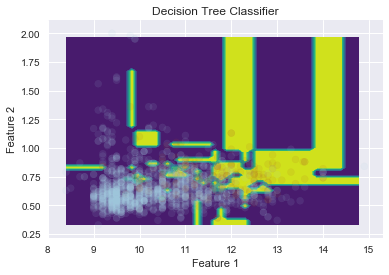

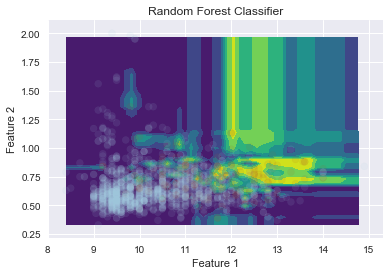

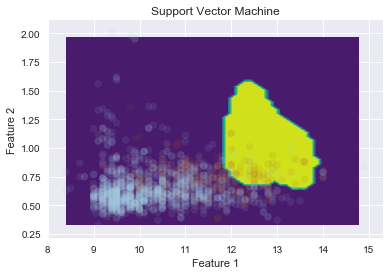

In [224]:
# your code here
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
imp_cols = clf.feature_importances_.argsort()[::-1][0:2]
X_imp = X[:,imp_cols]

classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(n_estimators=15),
               SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'Support Vector Machine']
for c in range(3):
    plt.title(titleClassifer[c])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plot_decision_surface(classifiers[c], X_imp, Y)

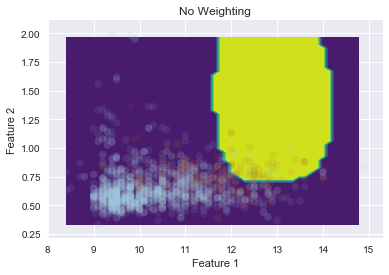

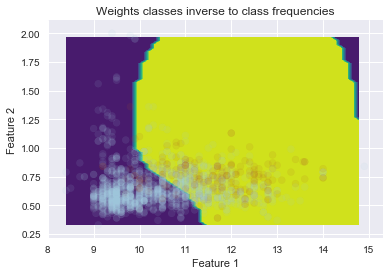

In [221]:
## Your Code here

classifiers = [sklearn.svm.SVC(C=1.0, gamma=1.0, class_weight=None),
               sklearn.svm.SVC(C=1.0, gamma=1.0, class_weight='balanced')]
 
titleClassifer = ['No Weighting', 'Weights classes inverse to class frequencies']

for c in range(2):
    plt.title(titleClassifer[c])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plot_decision_surface(classifiers[c], X_imp, Y)